# Primerjava analitike in numerike #

In [34]:
import lvm_read
import numpy  as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams.update({'text.usetex': True,
                     'font.size': 31,
                     'font.family':'lmodern',})

In [35]:
class MeritevStatike():
    ''' Take a .lvm file for analysis of ROC. '''
    def __init__(self, read_data):
        self.data = lvm_read.read(read_data)
    
    def sig(self):
        '''Returns signal[0] and signal length[1] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        return sig, N

    def time(self):
        '''Returns dt[0], fs[1] and total time[2] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        dt = self.data[0]['Delta_X'][0]
        fs = 1 / dt
        cajt = dt * np.arange(N)
        return dt, fs, cajt
    
    def instruments(self):
        '''
        Returns instrument data of measurment Class:
        0 - Sila
        1 - Pomik
        '''
        # Temperatura
        force = self.data[0]['data'][:,0]
        # Tok
        displacement = self.data[0]['data'][:,1]
        
        return force, displacement

In [36]:
data_1 = MeritevStatike('ver7_normal_full_h=1,5.lvm')
data_2 = MeritevStatike('ver7_normal_full_h=2,0.lvm')
data_3 = MeritevStatike('ver7_normal_full_h=2,5.lvm')
data_4 = MeritevStatike('ver7_normal_full_h=3,0.lvm')

## ROC statika ##

### Analitika ###

In [37]:
## Parametri
E = 2400 #MPa
t1 = 0.5 #mm
t2 = 0.25 #mm
h = 2.5 #6*t2 #mm
b = 4 #mm
I1 = b*t1**3 / 12 #mm^4
I2 = b*t2**3 / 12 #mm^4
l1 = 13 #mm
l2 = 20.37 #mm

# Analitične vrednosti togosti posameznih območij (Mathematica)
kp = 20.372*E*I1/l1**3
kn1 = 9250*E*I2/l2**3
kn2 = -1253.18*E*I2/l2**3
kn3 = 10571.42*E*I2/l2**3

#### Analitika (full ROC) ####

In [38]:
# celotne togosti in pomiki ROC
k1 = kp+1/2*kn1
k2 = kp+1/2*kn2
k3 = kp+1/2*kn3
dzg = 2*0.16*h
dsr = 2*1.33*h
dsp = 2*1.92*h
dk = 2*1.99*h
# skupne sile
F1 = k1*(dzg-0)
F2 = F1 + k2*(dsp-dzg)
F3 = F2 + k3*(dk-dsp)
# pozitivne sile
Fp = kp*dk
# negativne sile
Fzg = 1/2*kn1*(dzg-0)
Fsp = Fzg + 1/2*kn2*(dsp-dzg)

### Eksperiment ###

In [58]:
shift = 0.0 #mm
pomik_1 = -data_1.instruments()[1][::20]-shift #mm
sila_1 = data_1.instruments()[0][::20] #N

shift = 0.0 #mm
pomik_2 = -data_2.instruments()[1][::20]-shift #mm
sila_2 = data_2.instruments()[0][::20] #N

shift = 0.1 #mm
pomik_3 = -data_3.instruments()[1][::20]-shift #mm
sila_3 = data_3.instruments()[0][::20] #N

shift = 0.0 #mm
pomik_4 = -data_4.instruments()[1][::20]-shift #mm
sila_4 = data_4.instruments()[0][::20] #N

### Izris ###

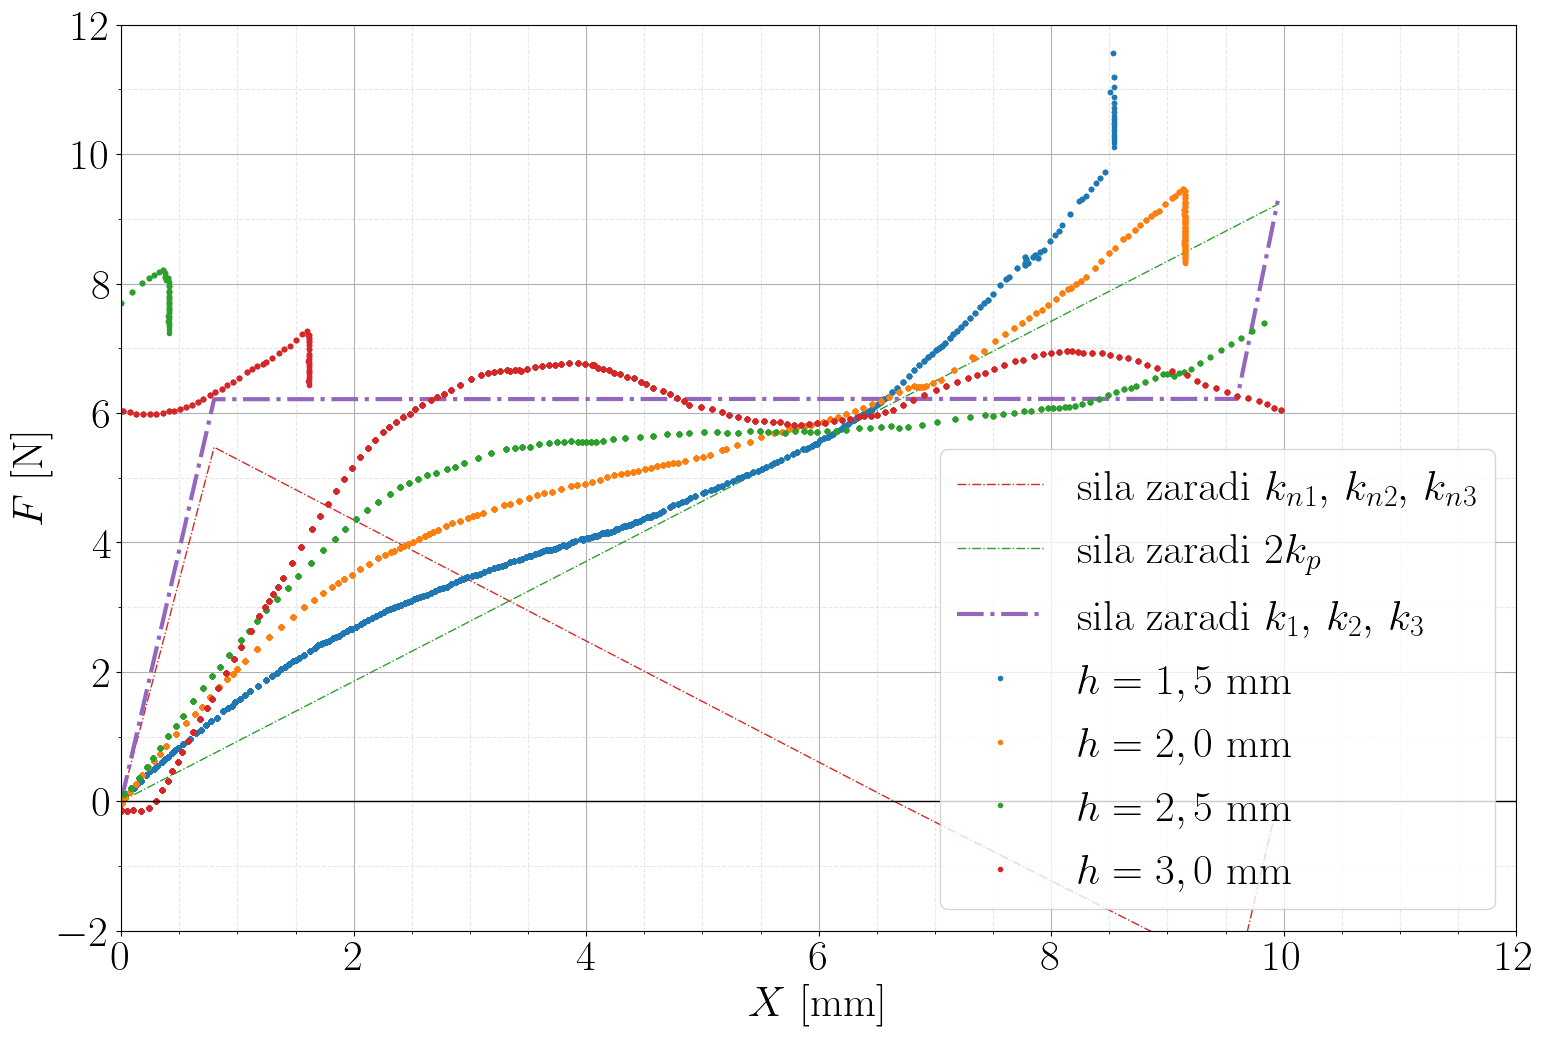

In [60]:
plt.rcParams['figure.figsize'] = [18, 12]

# Negativna sila
plt.plot(np.array([0, dzg, dsr, dsp, dk]), [0,Fzg,0,Fsp,0], linestyle="-.", lw=1, color='tab:red', label = r'sila zaradi $k_{n1}, \, k_{n2}, \, k_{n3}$')
# pozitivna sila
plt.plot([0, dk], [0, Fp], linestyle="-.", lw=1, color='tab:green', label=r'sila zaradi $2k_p$')
# skupna sila
plt.plot(np.array([0, dzg, dsr, dsp, dk]), np.array([0, F1, F2, F2, F3]), linestyle="-.", lw=3, color='tab:purple', label= r'sila zaradi $k_{1}, \, k_{2}, \, k_{3}$')

# eksperimentalna sila
plt.plot(pomik_1, sila_1, '.', label=r'$h=1,5$ mm')
plt.plot(pomik_2, sila_2, '.', label=r'$h=2,0$ mm')
plt.plot(pomik_3, sila_3, '.', label=r'$h=2,5$ mm')
plt.plot(pomik_4, sila_4, '.', label=r'$h=3,0$ mm')

plt.xlabel(r'$X$ [mm]')
plt.ylabel(r'$F$ [N]')
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)
plt.xlim(0, 12)
plt.ylim(-2, 12)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.show()